In [1]:
import torchvision.transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import math

In [2]:
epochs = 50
t_steps = 1000
batch_size = 64
lr = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация в [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Синусоидальные эмбеддинги для времени
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Residual Block с time embeddings
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        
        self.block1 = nn.Sequential(
            nn.GroupNorm(8, in_channels) if in_channels >= 8 else nn.BatchNorm2d(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )
        
        self.block2 = nn.Sequential(
            nn.GroupNorm(8, out_channels) if out_channels >= 8 else nn.BatchNorm2d(out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )
        
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.residual_conv = nn.Identity()
    
    def forward(self, x, t):
        h = self.block1(x)
        
        # Добавляем информацию о времени
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2]  # Добавляем размерности H, W
        h = h + time_emb
        
        h = self.block2(h)
        return h + self.residual_conv(x)

# Новая улучшенная UNet
class ImprovedUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, time_emb_dim=128):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Encoder
        self.conv1 = ResidualBlock(in_channels, 32, time_emb_dim)
        self.down1 = nn.Conv2d(32, 32, 4, 2, 1)  # 28x28 -> 14x14
        
        self.conv2 = ResidualBlock(32, 64, time_emb_dim)
        self.down2 = nn.Conv2d(64, 64, 4, 2, 1)  # 14x14 -> 7x7
        
        self.conv3 = ResidualBlock(64, 128, time_emb_dim)
        
        # Bottleneck
        self.bottleneck = ResidualBlock(128, 128, time_emb_dim)
        
        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)  # 7x7 -> 14x14
        self.conv4 = ResidualBlock(128, 64, time_emb_dim)  # 64 + 64 = 128
        
        self.up1 = nn.ConvTranspose2d(64, 32, 4, 2, 1)  # 14x14 -> 28x28
        self.conv5 = ResidualBlock(64, 32, time_emb_dim)  # 32 + 32 = 64
        
        # Output
        self.out = nn.Sequential(
            nn.GroupNorm(8, 32) if 32 >= 8 else nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.Conv2d(32, out_channels, 3, padding=1)
        )
    
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_mlp(t)
        
        # Encoder
        x1 = self.conv1(x, t_emb)
        x2 = self.conv2(self.down1(x1), t_emb)
        x3 = self.conv3(self.down2(x2), t_emb)
        
        # Bottleneck
        x4 = self.bottleneck(x3, t_emb)
        
        # Decoder with skip connections
        x = self.conv4(torch.cat([self.up2(x4), x2], dim=1), t_emb)
        x = self.conv5(torch.cat([self.up1(x), x1], dim=1), t_emb)
        
        return self.out(x)

In [5]:
def show_img_batch(images, images_count):
    plt.figure(figsize=(7, 5))
    for i in range(images.shape[0]):
        img = images[i].view(-1, 1, 28, 28)
        plt.subplot(1, images_count, i + 1)
        plt.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
        plt.title(f'Image {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
def simple_forward_diffusion(x0, t, T=1000):
    alpha = 1.0 - (t.float() / T)
    alpha = alpha.view(-1, 1, 1, 1).to(x0.device)

    noise = torch.randn_like(x0)
    noisy_images = alpha.sqrt() * x0 + (1 - alpha).sqrt() * noise

    return noisy_images, noise

In [7]:
class DDPMScheduler:
    def __init__(self, device, T=1000, beta_start=0.0001, beta_end=0.02):
        self.T = T
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0).to(device)

    def add_noise(self, x_start, t):
        # Выбираем alpha_bar_t для каждого изображения в батче
        sqrt_alphas_bar = torch.sqrt(self.alphas_bar[t])[:, None, None, None]
        sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - self.alphas_bar[t])[:, None, None, None]

        # Генерируем случайный Гауссовский шум (epsilon)
        noise = torch.randn_like(x_start).to(device)

        # Применяем формулу добавления шума
        x_t = sqrt_alphas_bar * x_start + sqrt_one_minus_alphas_bar * noise

        return x_t, noise


In [8]:
def train_one_epoch(model, scheduler, dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        images = data.to(device)

        t = torch.randint(0, scheduler.T, (images.shape[0],), device=device).long()

        x_t, true_noise = scheduler.add_noise(images, t)

        # 3. Предсказание шума (обратная диффузия)
        predicted_noise = model(x_t, t)

        # 4. Расчет L2-потери (MSE) между предсказанным и истинным шумом
        loss = nn.functional.mse_loss(predicted_noise, true_noise)

        # 5. Оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [9]:
@torch.no_grad()
def generate_images(model, scheduler, num_images, device):
    model.eval()

    x = torch.randn(num_images, 1, 28, 28, device=device)

    for t_step in tqdm(reversed(range(scheduler.T)), desc="Sampling", total=scheduler.T):
        t = torch.tensor([t_step] * num_images, device=device, dtype=torch.long)

        alpha_t = scheduler.alphas[t_step]
        alpha_bar_t = scheduler.alphas_bar[t_step]
        beta_t = scheduler.betas[t_step]

        predicted_noise = model(x, t)

        # Формула для оценки x_{t-1} из x_t (наивный вариант)
        # x_{t-1} = 1/sqrt(alpha_t) * (x_t - (1-alpha_t)/sqrt(1-alpha_bar_t) * predicted_noise) + sigma_t * z

        # Коэффициент для "чистой" части изображения
        mean_coefficient = 1.0 / torch.sqrt(alpha_t)

        # Коэффициент для предсказанного шума
        noise_coefficient = (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t)

        # Расчет "среднего" (mu_t) для перехода к x_{t-1}
        mu_t = mean_coefficient * (x - noise_coefficient * predicted_noise)

        if t_step > 0:
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = mu_t + sigma_t * noise
        else:
            x = mu_t

    x = (x.clamp(-1, 1) + 1) / 2
    return x.cpu()


In [10]:
model = ImprovedUNet().to(device)
scheduler = DDPMScheduler(T=t_steps, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [11]:
losses = []

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 617.13it/s]


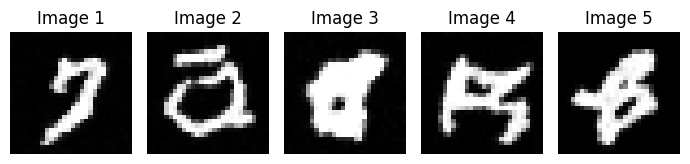

Epoch 1/50, Loss: 0.0465


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 613.27it/s]


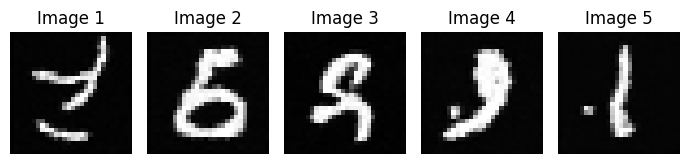

Epoch 2/50, Loss: 0.0295


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 632.12it/s]


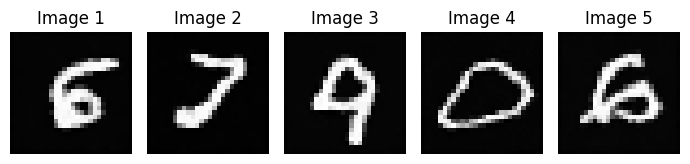

Epoch 3/50, Loss: 0.0274


Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 256.85it/s]


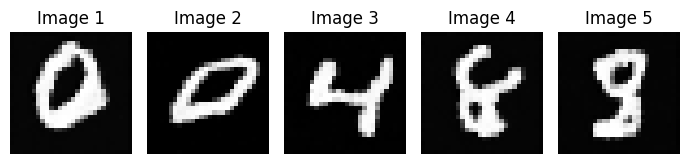

Epoch 4/50, Loss: 0.0263


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 632.64it/s]


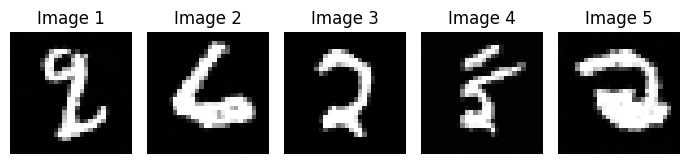

Epoch 5/50, Loss: 0.0254


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 641.63it/s]


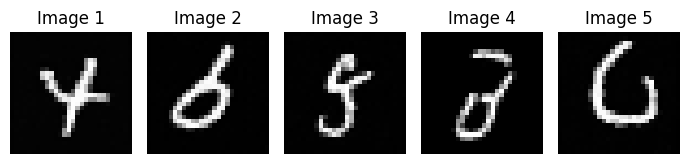

Epoch 6/50, Loss: 0.0251


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 619.70it/s]


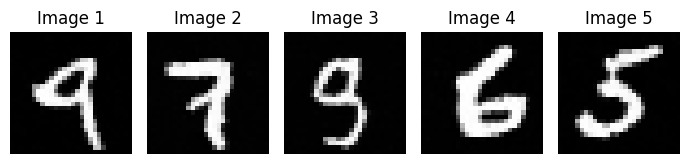

Epoch 7/50, Loss: 0.0244


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 620.04it/s]


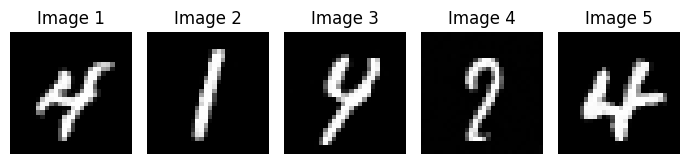

Epoch 8/50, Loss: 0.0241


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 644.52it/s]


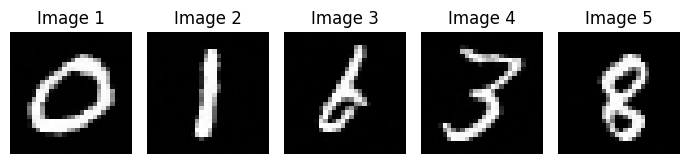

Epoch 9/50, Loss: 0.0240


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 635.44it/s]


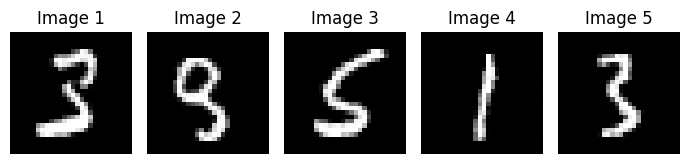

Epoch 10/50, Loss: 0.0243


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 607.29it/s]


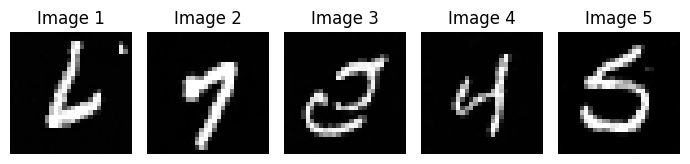

Epoch 11/50, Loss: 0.0235


Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 252.86it/s]


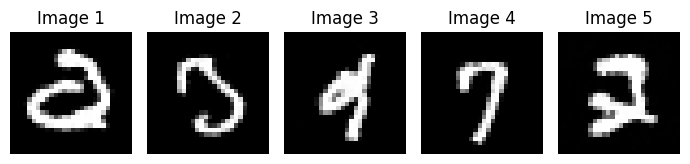

Epoch 12/50, Loss: 0.0235


Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 254.13it/s]


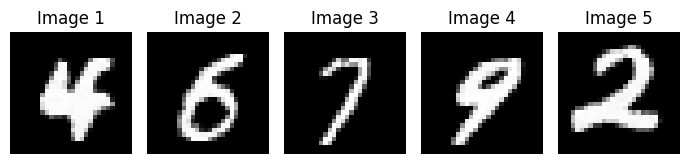

Epoch 13/50, Loss: 0.0232


Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 253.06it/s]


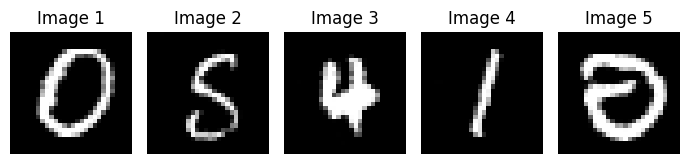

Epoch 14/50, Loss: 0.0230


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 638.62it/s]


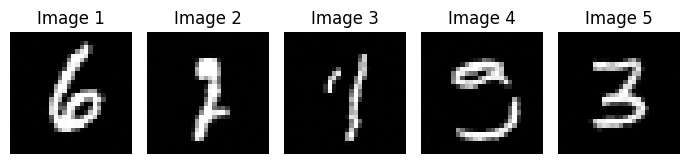

Epoch 15/50, Loss: 0.0229


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 625.79it/s]


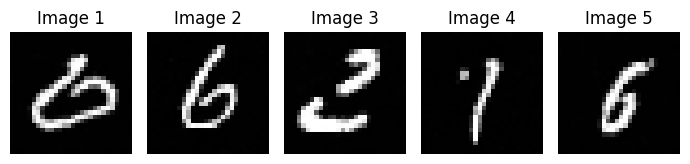

Epoch 16/50, Loss: 0.0227


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 624.98it/s]


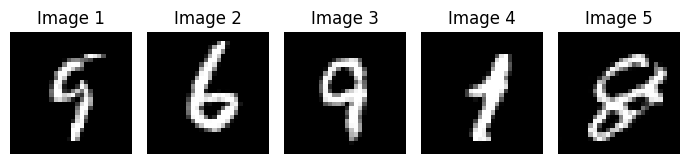

Epoch 17/50, Loss: 0.0229


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 629.33it/s]


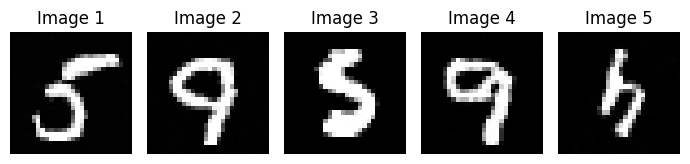

Epoch 18/50, Loss: 0.0229


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 608.16it/s]


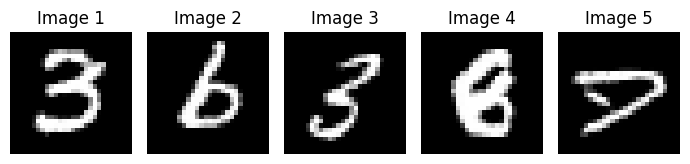

Epoch 19/50, Loss: 0.0228


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 657.61it/s]


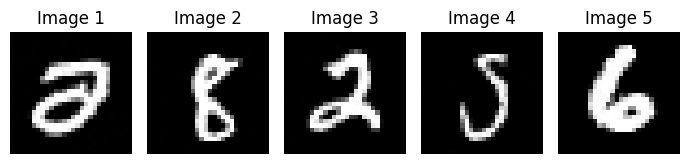

Epoch 20/50, Loss: 0.0226


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 640.68it/s]


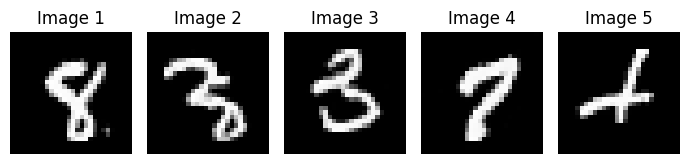

Epoch 21/50, Loss: 0.0225


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 627.33it/s]


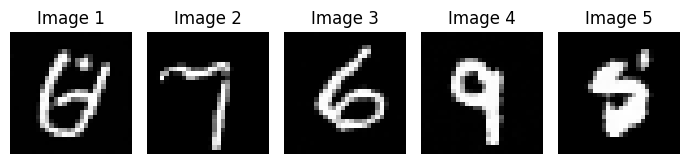

Epoch 22/50, Loss: 0.0227


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 625.17it/s]


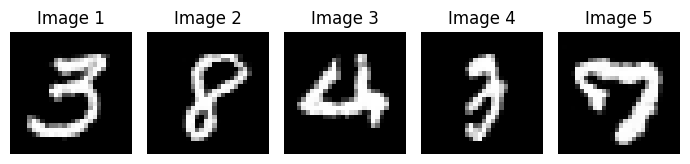

Epoch 23/50, Loss: 0.0225


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 638.37it/s]


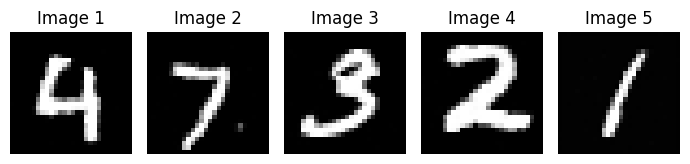

Epoch 24/50, Loss: 0.0223


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 655.31it/s]


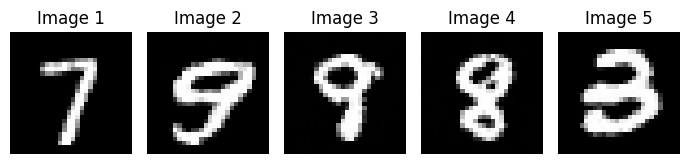

Epoch 25/50, Loss: 0.0225


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 631.11it/s]


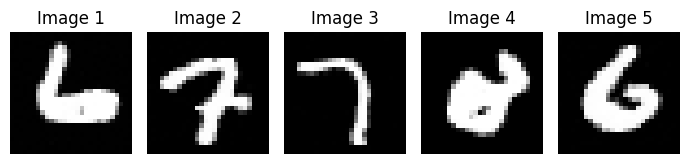

Epoch 26/50, Loss: 0.0223


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 647.91it/s]


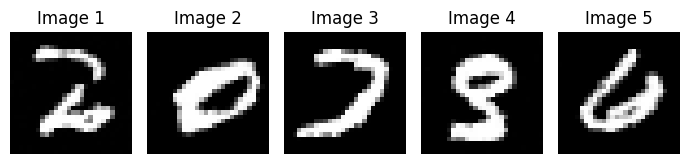

Epoch 27/50, Loss: 0.0225


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 638.67it/s]


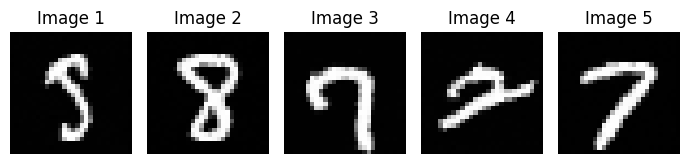

Epoch 28/50, Loss: 0.0221


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 631.51it/s]


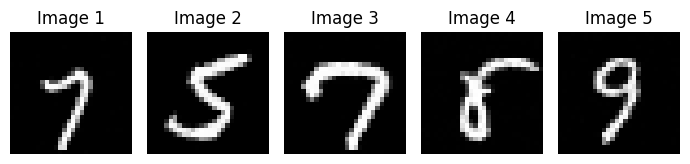

Epoch 29/50, Loss: 0.0223


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 624.94it/s]


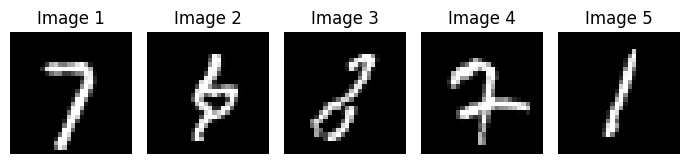

Epoch 30/50, Loss: 0.0224


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 645.47it/s]


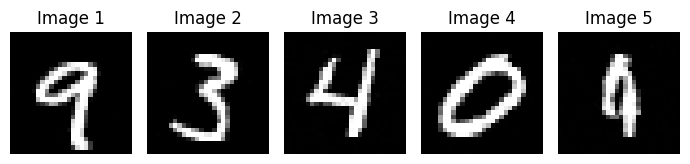

Epoch 31/50, Loss: 0.0224


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 643.60it/s]


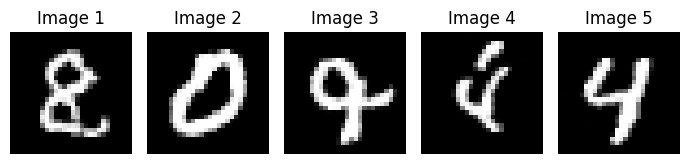

Epoch 32/50, Loss: 0.0220


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 651.79it/s]


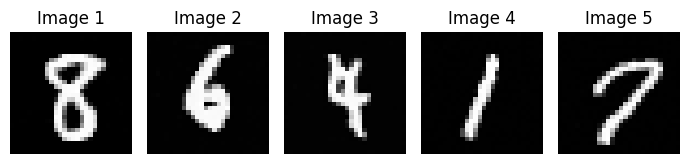

Epoch 33/50, Loss: 0.0220


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 654.68it/s]


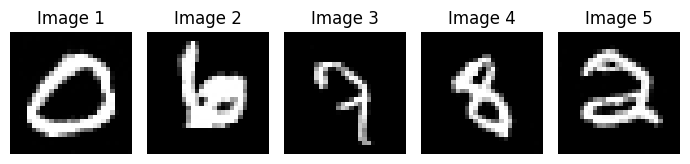

Epoch 34/50, Loss: 0.0222


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 634.32it/s]


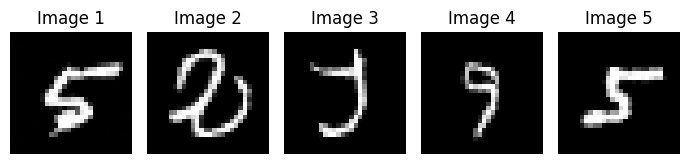

Epoch 35/50, Loss: 0.0223


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 629.15it/s]


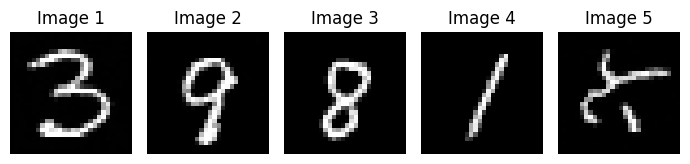

Epoch 36/50, Loss: 0.0221


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 631.54it/s]


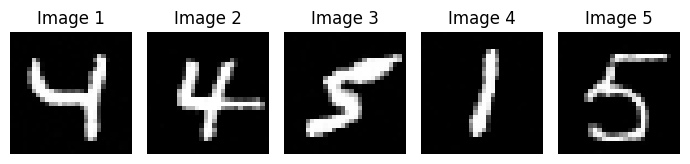

Epoch 37/50, Loss: 0.0219


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 631.69it/s]


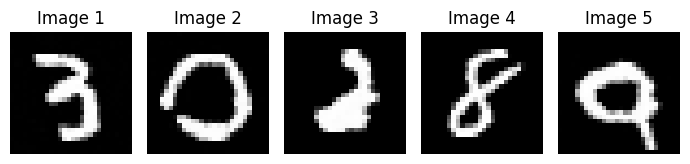

Epoch 38/50, Loss: 0.0221


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 658.94it/s]


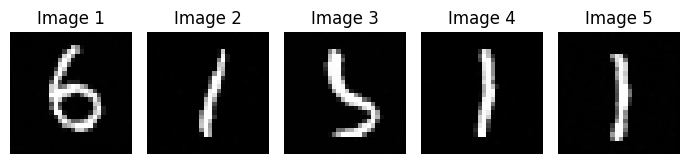

Epoch 39/50, Loss: 0.0219


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 652.17it/s]


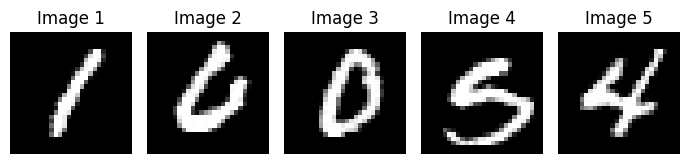

Epoch 40/50, Loss: 0.0219


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 629.58it/s]


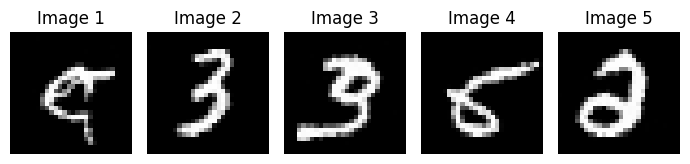

Epoch 41/50, Loss: 0.0220


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 647.70it/s]


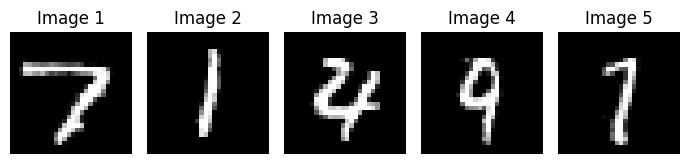

Epoch 42/50, Loss: 0.0219


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 643.23it/s]


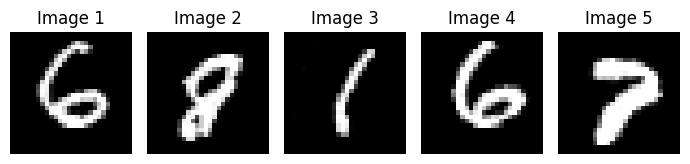

Epoch 43/50, Loss: 0.0217


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 638.75it/s]


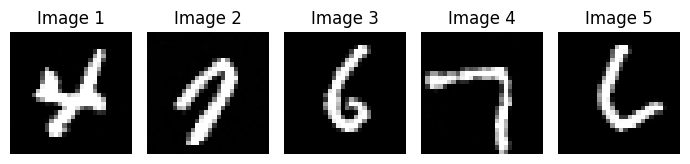

Epoch 44/50, Loss: 0.0220


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 629.27it/s]


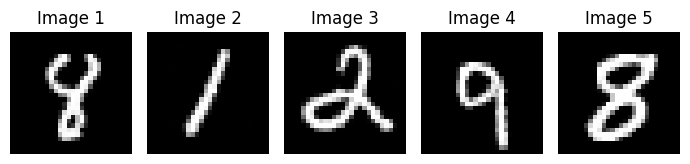

Epoch 45/50, Loss: 0.0217


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 625.00it/s]


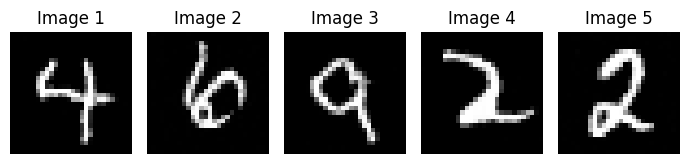

Epoch 46/50, Loss: 0.0218


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 624.98it/s]


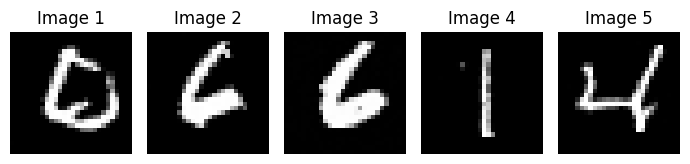

Epoch 47/50, Loss: 0.0216


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 624.35it/s]


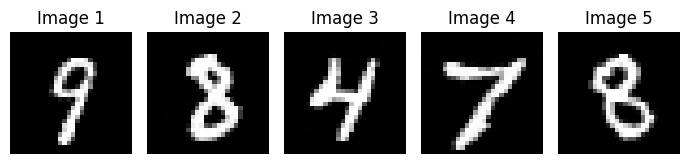

Epoch 48/50, Loss: 0.0219


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 651.78it/s]


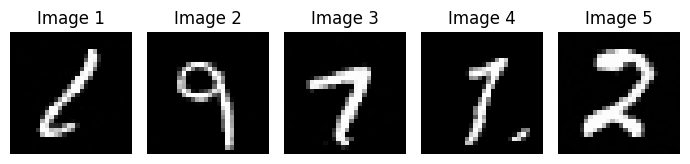

Epoch 49/50, Loss: 0.0218


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 625.00it/s]


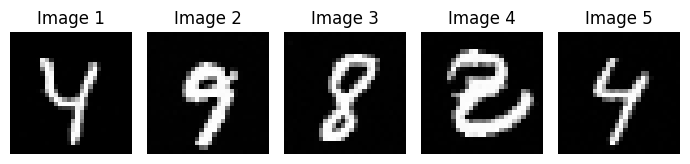

Epoch 50/50, Loss: 0.0217


In [12]:
for epoch in range(epochs):
        avg_loss = train_one_epoch(model, scheduler, train_loader, optimizer, device)
        losses.append(avg_loss)
        images = generate_images(model, scheduler, 5, device)
        show_img_batch(images, 5)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 644.11it/s]


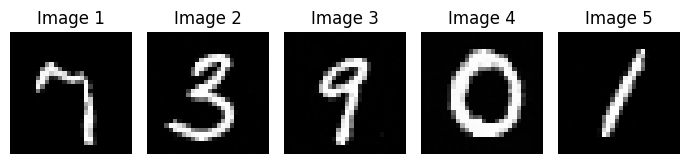

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 651.86it/s]


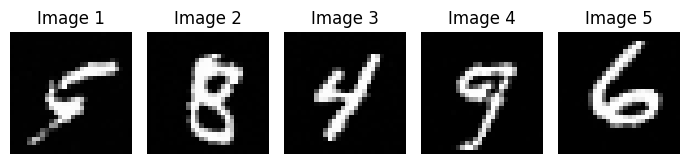

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 658.61it/s]


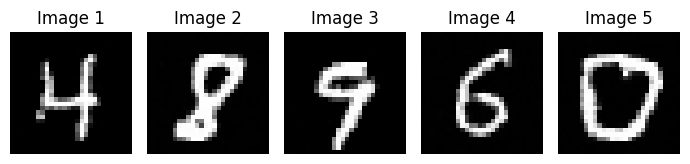

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 649.96it/s]


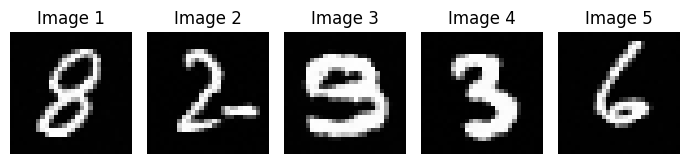

Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 646.50it/s]


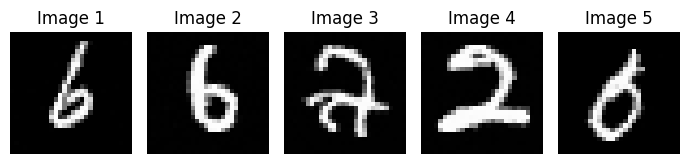

In [14]:
for i in range(5):
    images = generate_images(model, scheduler, 5, device)
    show_img_batch(images, 5)